In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pymannkendall
import eofs.xarray


## load jet winds data

In [2]:
k06 = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_*100to400*.nc') # before: 

In [3]:
k06

<xarray.Dataset> Size: 4GB
Dimensions:              (time: 30436, lat: 91, lon: 360)
Coordinates:
    plev                 int64 8B 100
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 364B 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 243kB 1940-01-01 ... 2023-04-30
Data variables:
    weighted_average_ws  (time, lat, lon) float32 4GB dask.array<chunksize=(6940, 91, 360), meta=np.ndarray>

### normalise data

In [4]:
KOCH_WS_MONTH_MEAN = k06['weighted_average_ws'].groupby('time.month').mean('time')

In [5]:
def normalise_data(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
    
# def get_formatted_koch_imgs_normalised(row):
#     row = normalise_data(row.values.astype(float))
#     return row


def get_month_anom(row):
    row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

# def get_formatted_koch_imgs_normalised_month_anom_relative(row):
#     row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
#     row_month_anom = normalise_data(row_month_anom.values.astype(float))
#     return row_month_anom

In [6]:
%%time
k06['weighted_average_ws'].load();

CPU times: user 569 ms, sys: 1.05 s, total: 1.62 s
Wall time: 1.62 s


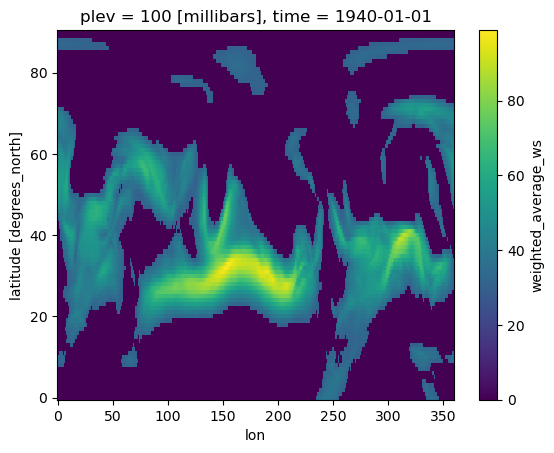

In [7]:
k06['weighted_average_ws'].isel(time=0).plot()

In [8]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc'):
    print('loading norm data')
    k06['jet_events_ws_norm'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')
else:
    print('making norm data')
    k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)
    k06['jet_events_ws_norm'].to_netcdf('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')

loading norm data
CPU times: user 6.53 ms, sys: 3.19 ms, total: 9.72 ms
Wall time: 9.18 ms


# load extreme ('persistent') cold data

In [9]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

## cluster groups

In [10]:
NUM_DAYS_BREAK = 1

def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters


In [11]:
no_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '000')\
                                            ).dropna(dim='time')

In [12]:
no_coldair_event_djf = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['DJF']))
no_coldair_event_mam = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['MAM']))
no_coldair_event_jja = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['JJA']))
no_coldair_event_son = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['SON']))


# Look at all cold air codes 

In [13]:
all_cold_event_codes = np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

In [14]:
np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

array(['000', '001', '010', '011', '100', '101', '110', '111'],
      dtype='<U3')

In [15]:
THRESHOLD_FOR_CROSSHATCH = 0.66 ## 66%

In [16]:
extreme_cold_persist_thresh.load()

<xarray.Dataset> Size: 3MB
Dimensions:                          (lon: 91, lat: 41, time: 30435,
                                      ar6_region: 3)
Coordinates:
  * lon                              (lon) float32 364B -130.0 -129.0 ... -40.0
  * lat                              (lat) float32 164B 20.0 21.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 243kB 1940-01-01 ....
    dayofyear                        (time) int64 243kB 1 2 3 4 ... 118 119 120
    quantile                         float64 8B 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 243kB 0.0 0.0 ... 0.0 0.0
    cna_perc_coverage                (time) float64 243kB 0.3745 9.363 ... 0.0
    ena_perc_coverage                (time) float64 243kB 6.105 8.43 ... 0.0 0.0
    cold_air_event_WNA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_CNA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_ENA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_stacked           (ar6_region, time) int64 730kB 0 0 ... 0 0
    cold_air_event_stacked_names     (time) <U3 365kB '000' '000' ... '000'
    cold_air_event_stacked_codified  (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0

In [17]:
def make_k06_season_ds(season_composite_ds, season):
    for coldairevent_code in all_cold_event_codes:
        # if coldairevent_code == '101':
        #     continue
        onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                                ).dropna(dim='time')
        onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([season]))
        if onetype_coldair_event_djf.time.size < 1:
            continue
        print(coldairevent_code)
        cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event_djf.time)
        k06_my_persist = k06.sel(time=onetype_coldair_event_djf.time.data)
        for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
            if ind == 0:
                k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
            else:
                k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
        if 'time' not in k06_my_persist_weighted.dims:
            print('time not in dims')
            k06_my_persist_weighted = k06_my_persist_weighted.expand_dims('time')
        
        k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')
        sign_crosshatching = np.sign(k06_my_persist_weighted['jet_events_ws_norm']) == np.sign(k06_my_persist_mean_weighted['jet_events_ws_norm'])
        sign_crosshatching_time_mean = sign_crosshatching.sum(('time'))
        sign_crosshatching_time_mean_mask = (sign_crosshatching_time_mean / k06_my_persist_weighted.time.size) > THRESHOLD_FOR_CROSSHATCH
        
        season_composite_ds[coldairevent_code] = k06_my_persist_mean_weighted['jet_events_ws_norm']
        season_composite_ds[f'{coldairevent_code}_mask'] = sign_crosshatching_time_mean_mask
    return season_composite_ds

In [18]:
if not os.path.exists('outputs/all_k06_composites_100to400.nc'):
    print('making k06 composites')
    djf_k06_composites = xr.Dataset()
    mam_k06_composites = xr.Dataset()
    jja_k06_composites = xr.Dataset()
    son_k06_composites = xr.Dataset()
    
    djf_k06_composites = make_k06_season_ds(djf_k06_composites, 'DJF')
    mam_k06_composites = make_k06_season_ds(mam_k06_composites, 'MAM')
    jja_k06_composites = make_k06_season_ds(jja_k06_composites, 'JJA')
    son_k06_composites = make_k06_season_ds(son_k06_composites, 'SON')
    all_k06_composites = xr.concat([djf_k06_composites, mam_k06_composites, jja_k06_composites, son_k06_composites], dim='season')
    all_k06_composites['season'] = ['DJF', 'MAM', 'JJA', 'SON']
    all_k06_composites.to_netcdf('outputs/all_k06_composites_100to400.nc')
else:
    print('loading k06 composites')
    all_k06_composites = xr.open_dataset('outputs/all_k06_composites_100to400.nc')

loading k06 composites


In [19]:
def cluster_count(data, season='annual'):
    clustered_count = {}
    if season != 'annual':
        data = data.sel(time=data.time.dt.season.isin([season]))
    for event_code in np.unique(data['cold_air_event_stacked_names']):
        onetype_coldair_event = data.where((data['cold_air_event_stacked_names'] == event_code)\
                                                    ).dropna(dim='time')
        clustered_count[int(event_code[0]), int(event_code[1]), int(event_code[2])] = len(cluster_datetimes(onetype_coldair_event.time))
    return clustered_count

In [20]:
%%time
clustered_count_djf = cluster_count(extreme_cold_persist_thresh, season='DJF')

CPU times: user 15.4 s, sys: 5.19 ms, total: 15.4 s
Wall time: 15.4 s


In [21]:
clustered_count_djf

{(0, 0, 0): 475,
 (0, 0, 1): 219,
 (0, 1, 0): 146,
 (0, 1, 1): 45,
 (1, 0, 0): 132,
 (1, 1, 0): 70,
 (1, 1, 1): 7}

In [22]:
djf_cold_event_codes = ['001', '010', '100', '011', '110', '111']

In [23]:
djf_mean = k06['weighted_average_ws'].sel(time=k06.time.dt.season.isin(['DJF'])).mean('time')
son_mean = k06['weighted_average_ws'].sel(time=k06.time.dt.season.isin(['SON'])).mean('time')

In [24]:
cao_code_names = {'001':'E', '011':'CE', '010':'C', '110':'WC', '100':'W', '111':'WCE'}

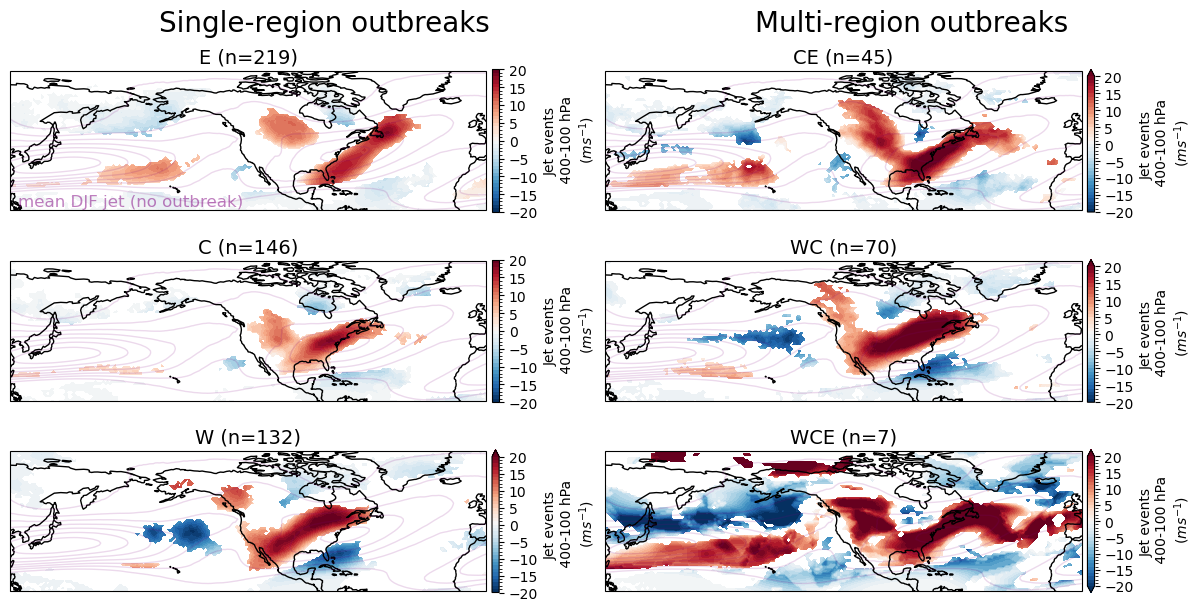

In [25]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True, subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
djf_cold_event_codes_reordered = ['001', '011', '010', '110', '100', '111']
for ind, ax in enumerate(axes.reshape(-1)):
    cao_code = djf_cold_event_codes_reordered[ind]
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cao_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    djf_mean.plot.contour(colors='purple', transform=box_proj, levels=np.arange(0, 80, 10), linewidths=1, ax=ax, alpha=.15)
    all_k06_composites_66perc = all_k06_composites[cao_code].sel(season='DJF').where(all_k06_composites[f'{cao_code}_mask'].sel(season='DJF'))
    all_k06_composites_66perc.plot.contourf(levels=np.arange(-20, 21), transform=box_proj,  center=0, ax=ax, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.9, 'pad':.01, 'orientation':'vertical', 'label': f'Jet events\n 400-100 hPa\n {mps}'})
    cao_title = f"{cao_code_names[cao_code]} (n={cluster_count(onetype_coldair_event_djf, season='DJF')[int(cao_code[0]), int(cao_code[1]), int(cao_code[2])]})"
    ax.set_title(f"{cao_title}", size=14)
    ax.coastlines()
    ax.set_extent([120, 359, 10, 80], crs=box_proj)
axes[0][0].text(s="Single-region outbreaks", x=15, y=100, size=20)
axes[0][1].text(s="Multi-region outbreaks", x=15, y=100, size=20)
axes[0][0].text(s="mean DJF jet (no outbreak)", x=-56, y=12.4, color='purple', alpha=.5, size=12)
fig.subplots_adjust(wspace=.05)
# fig.savefig('figures/djf_koch_composites_singlemultiregion_npac.png', dpi=300,  bbox_inches='tight')

# Geopotential alternative

In [26]:
zg = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_79to23.nc')

In [27]:
# QUICK VERSION
# ZG_MONTH_MEAN = zg['z'].resample(time='1ME').mean()
# ZG_MONTH_MEAN = ZG_MONTH_MEAN.groupby('time.month').mean('time')

In [28]:
# ZG_MONTH_MEAN.to_netcdf("zg_month_mean.nc")

In [ ]:
# ZG_MONTH_MEAN = xr.open_dataset("zg_month_mean.nc")

In [29]:
def get_month_anom_zg(row):
    row_month_anom = row - ZG_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

In [30]:
# %%time
# zg['z_anom'] = zg['z'].groupby('time').apply(get_month_anom_zg)

CPU times: user 52min 32s, sys: 2min 38s, total: 55min 10s
Wall time: 55min 12s


In [31]:
zg

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 5411, lat: 90, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 43kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lat      (lat) float64 720B 0.0 1.0 2.0 3.0 4.0 ... 85.0 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    month    (time) int64 43kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    z        (time, lat, lon) float32 701MB ...
    z_anom   (time, lat, lon) float32 701MB -155.7 -145.7 ... 1.182e+03
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-06T12:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [32]:
# zg['z_anom'].to_netcdf('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc')

In [33]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc'):
    print('loading norm data')
    zg['z_anom'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc')
else:
    print('making norm data')
    zg['z_anom'] = zg['z'].groupby('time').apply(get_month_anom_zg)
    zg['z_anom'].to_netcdf('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc')

loading norm data
CPU times: user 6.71 ms, sys: 3.04 ms, total: 9.74 ms
Wall time: 9.35 ms


In [34]:
def make_zg_season_ds(season_composite_ds, season):
    for coldairevent_code in all_cold_event_codes:
        # if coldairevent_code == '101':
        #     continue
        onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                                ).dropna(dim='time')
        onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([season]))
        if onetype_coldair_event_djf.time.size < 1:
            continue
        print(coldairevent_code)
        cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event_djf.time)
        zg_my_persist = zg.sel(time=onetype_coldair_event_djf.time.data)
        for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
            if ind == 0:
                zg_my_persist_weighted = zg_my_persist.sel(time=dt_cluster).mean('time')
            else:
                zg_my_persist_weighted = xr.concat([zg_my_persist_weighted, zg_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
        if 'time' not in zg_my_persist_weighted.dims:
            print('time not in dims')
            zg_my_persist_weighted = zg_my_persist_weighted.expand_dims('time')
        
        zg_my_persist_mean_weighted = zg_my_persist_weighted.mean('time')
        sign_crosshatching = np.sign(zg_my_persist_weighted['z_anom']) == np.sign(zg_my_persist_mean_weighted['z_anom'])
        sign_crosshatching_time_mean = sign_crosshatching.sum(('time'))
        sign_crosshatching_time_mean_mask = (sign_crosshatching_time_mean / zg_my_persist_weighted.time.size) > THRESHOLD_FOR_CROSSHATCH
        
        season_composite_ds[coldairevent_code] = zg_my_persist_mean_weighted['z_anom']
        season_composite_ds[f'{coldairevent_code}_mask'] = sign_crosshatching_time_mean_mask
    return season_composite_ds

In [35]:
if not os.path.exists('outputs/all_zg_composites.nc'):
    print('making zg composites')
    djf_zg_composites = xr.Dataset()
    mam_zg_composites = xr.Dataset()
    jja_zg_composites = xr.Dataset()
    son_zg_composites = xr.Dataset()
    
    djf_zh_composites = make_zg_season_ds(djf_zg_composites, 'DJF')
    mam_zh_composites = make_zg_season_ds(mam_zg_composites, 'MAM')
    jja_zh_composites = make_zg_season_ds(jja_zg_composites, 'JJA')
    son_zh_composites = make_zg_season_ds(son_zg_composites, 'SON')
    all_zg_composites = xr.concat([djf_zg_composites, mam_zg_composites, jja_zg_composites, son_zg_composites], dim='season')
    all_zg_composites['season'] = ['DJF', 'MAM', 'JJA', 'SON']
    all_zg_composites.to_netcdf('outputs/all_zg_composites.nc')
else:
    print('loading zg composites')
    all_zg_composites = xr.open_dataset('outputs/all_zg_composites.nc')

loading zg composites


In [36]:
djf_zg_mean = zg['z_anom'].sel(time=zg.time.dt.season.isin(['DJF'])).mean('time')

## Plot ZG

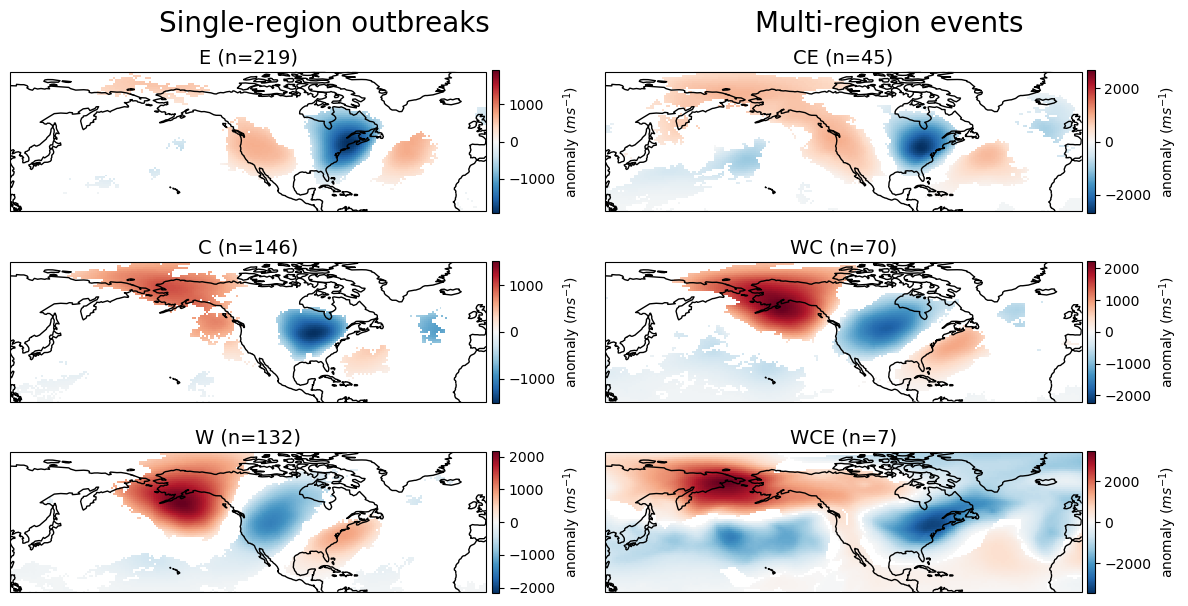

In [38]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True, subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
djf_cold_event_codes_reordered = ['001', '011', '010', '110', '100', '111']
for ind, ax in enumerate(axes.reshape(-1)):
    cao_code = djf_cold_event_codes_reordered[ind]
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cao_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    # djf_zg_mean.plot.contour(colors='purple', transform=box_proj, linewidths=1, ax=ax, alpha=.15)
    all_zg_composites_66perc = all_zg_composites[cao_code].sel(season='DJF').where(all_zg_composites[f'{cao_code}_mask'].sel(season='DJF'))
    all_zg_composites_66perc.plot(transform=box_proj, center=0, ax=ax, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.9, 'pad':.01, 'orientation':'vertical', 'label': r'anomaly ($ms^{-1}$)'})
    cao_title = f"{cao_code_names[cao_code]} (n={cluster_count(onetype_coldair_event_djf, season='DJF')[int(cao_code[0]), int(cao_code[1]), int(cao_code[2])]})"
    ax.set_title(f"{cao_title}", size=14)
    ax.coastlines()
    ax.set_extent([120, 359, 10, 80], crs=box_proj)
axes[0][0].text(s="Single-region outbreaks", x=15, y=100, size=20)
axes[0][1].text(s="Multi-region events", x=15, y=100, size=20)
# axes[0][0].text(s="mean DJF jet (no event)", x=-56, y=12.4, color='purple', alpha=.5, size=12)
fig.subplots_adjust(wspace=.05)
# fig.savefig('figures/djf_zg_composites_singlemulticodes_npac.png', dpi=300,  bbox_inches='tight')